In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
# important to set a keras random seed for reproducibility on the LSTM model
tf.keras.utils.set_random_seed(42)

from keras.models import Sequential
from keras.layers import Dense, LSTM

# Change to statsmodels.tsa.arima.model on jupyter notebook.
# statsmodels.tsa.arima_model for google colab
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from fbprophet import Prophet

import warnings
warnings.simplefilter('ignore')

plt.style.use("fivethirtyeight")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# uploading csv file on google colab 
# skip cell if working on jupyter notebook

from google.colab import files
uploaded = files.upload()

Saving index_funds_data.csv to index_funds_data.csv


We begin by importing our funds csv and selecting the data for the ticker name of interest. The price that we will be focusing on will be the Close price of the fund, therefore we will only concern ourselves with the close column. We will also take the opportunity convert the date column into a datetime object.

In [ ]:
# change the file path to "./data/index_funds_data.csv" if working on jupyter notebook

funds = pd.read_csv('index_funds_data.csv')
funds['date'] = pd.to_datetime(funds['date'],infer_datetime_format=True)
funds = funds[['symbol','date','close']]
funds = funds.set_index(['symbol','date'])
FXAIX = funds.loc['FXAIX',['close']]

### Visualize The Closing Price

Below we plot the time series for the fund to get an initial look at what the series looks like.

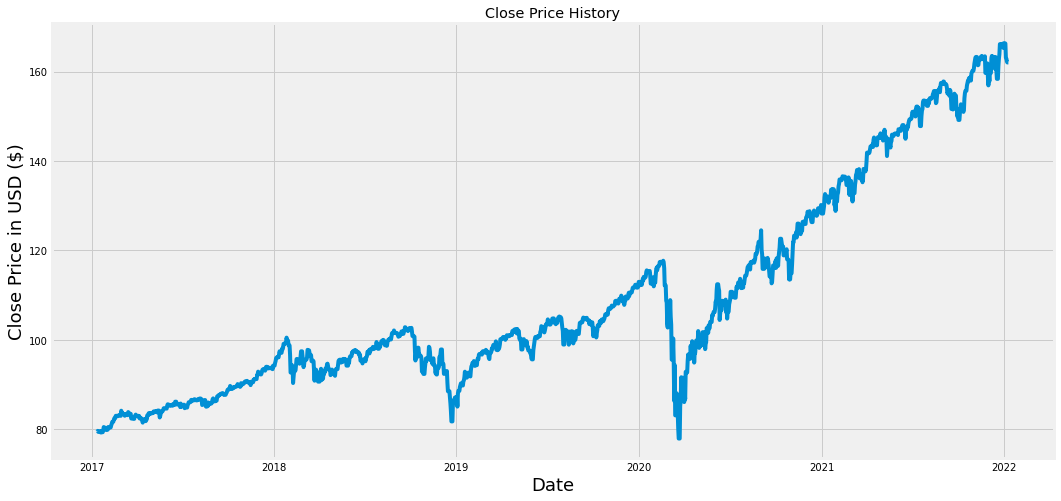

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(FXAIX['close'])
plt.title("Close Price History")
plt.xlabel("Date",fontsize=18)
plt.ylabel("Close Price in USD ($)",fontsize=18)
plt.show()

### Baseline "Naive" Model

To set up a baseline model, we shift the time series by 60 days forward. This is known a naive forecast.  

In [ ]:
FXAIX_baseline = FXAIX.shift(60)
FXAIX_base_rmse = mean_squared_error(FXAIX[60:],FXAIX_baseline[60:],squared=False)
FXAIX_base_rmse

7.2484654505696575

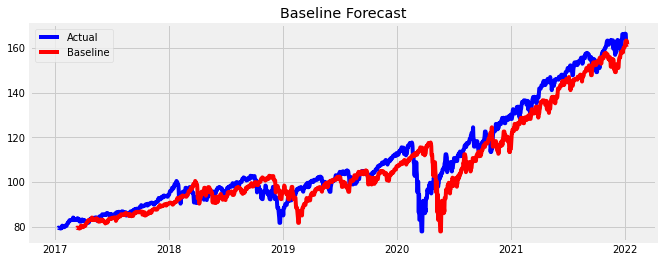

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title("Baseline Forecast")
ax.plot(FXAIX,c='b',label='Actual')
ax.plot(FXAIX_baseline,c='r',label='Baseline')
plt.legend()
plt.show()

To test the performance of our baseline we decide on a cutoff to split our original time series into the train set and test set. We also split the time series of our baseline using the same cutoff to create a the train predictions and test predictions. Next we calculate the RMSE of the baseline using the test predictions and the actual values, which is the test set from the original time series.

In [ ]:
new_df = pd.DataFrame()
new_df['original'] = FXAIX['close']
new_df['shifted'] = FXAIX['close'].shift(60)
cutoff = int(len(new_df['original']) * 0.80)
original = new_df['original']
shifted = new_df['shifted']
original_train, original_test = original[60:cutoff], original[cutoff:]
shifted_train, shifted_test = shifted[60:cutoff], shifted[cutoff:]

In [ ]:
baseline_rmse = mean_squared_error(original_train,shifted_train,squared=False)
baseline_rmse

7.390902158348852

To help visualize the results from the baseline, we plot each set below.

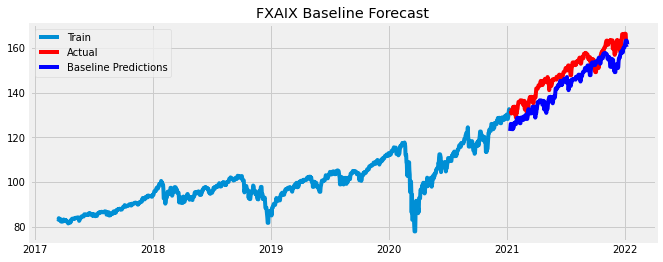

In [ ]:
plt.figure(figsize=(10,4))
plt.title('FXAIX Baseline Forecast')
plt.plot(original_train,label='Train')
plt.plot(original_test,c='r',label='Actual')
plt.plot(shifted_test,c='blue',label='Baseline Predictions')
plt.legend()
plt.show()

### ARIMA Modeling
Next, we move on to the next modeling techinique. We have defined various helper functions below to help us with the ARIMA modeling process.

As we recall from the EDA notebook, the time series is not stationary to begin with. Applying differencing was able to convert the time series to a stationary one. So we can expect to have an ARIMA model with at least a first order differencing. 

In [ ]:
# Arima Helper Functions

# get all possible combinations of (p,d,q) for a range (n,k)
def get_combos(n,k):
    p = d = q = range(n, k)
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]
    return pdqs

# find the optimal order for arima model for a series
def get_optimal_params(ts,n,k):
    pdq = get_combos(n,k)
    ans = []
    for comb in pdq:
        try:
            model = ARIMA(ts,
                         order=comb)
            output = model.fit()
            ans.append([comb,output.aic])
        except:
            continue
    ans_df = pd.DataFrame(ans, columns=['pdq','aic'])
    optimals = ans_df.loc[ans_df['aic'].idxmin()]
    return optimals

# fit arima model
def arima_models(ts,n,k):
    order = get_optimal_params(ts,n,k)['pdq']
    model = ARIMA(ts,
                 order=order)
    output = model.fit()
    return output

# time series train test split
def train_test_splt(ts,test_size):
    cutoff = int(ts.shape[0]*(1-test_size))
    train = ts[:cutoff]
    test = ts[cutoff:]
    return train, test

def find_rmse(model, test_data):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return y_hat, np.sqrt(mean_squared_error(test_data, y_hat))


In [ ]:
FXAIX_train, FXAIX_test = train_test_splt(FXAIX,.2)

# Find optimal pdq
print(get_optimal_params(FXAIX_train,0,3))

# Fit ARIMA with optimal pdq
arima_model = arima_models(FXAIX_train,0,3)

# Summary of model
arima_model.summary()

pdq    (2, 1, 2)
aic      4163.95
Name: 22, dtype: object


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                 1459
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2075.976
Method:                       css-mle   S.D. of innovations              1.004
Date:                Mon, 24 Jan 2022   AIC                           4163.952
Time:                        20:20:56   BIC                           4195.665
Sample:                    01-13-2017   HQIC                          4175.782
                         - 01-10-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0358      0.025      1.437      0.151      -0.013       0.085
ar.L1.D.close    -1.8260      0.023    -78.517      0.000      -1.872      -1.780
ar.L2.D.close    -0.8910      0.023    -39.528      0.000      -0.935      -0.847
ma.L1.D.close     1.7409      0.031     55.270      0.000       1.679       1.803
ma.L2.D.close     0.7839      0.030     26.073      0.000       0.725       0.843
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0246           -0.2692j            1.0594           -0.4591
AR.2           -1.0246           +0.2692j            1.0594            0.4591
MA.1           -1.1104           -0.2065j            1.1295           -0.4707
MA.2           -1.1104           +0.2065j            1.1295            0.4707
-----------------------------------------------------------------------------
"""

Looking at the ARIMA summary table, we can see that the model did in fact apply differencing to our model. Our p-values on our coefficients are low enough, which tell us that they are significant. After an iterative search for the best parameter, this is the best fitting ARIMA model with the lowest AIC score.

Next we will calculate the RMSE for this model to evaluate it's performance.

In [ ]:
yhat ,arima_rmse = find_rmse(arima_model,FXAIX_test)

In [ ]:
arima_rmse

12.634808742698912

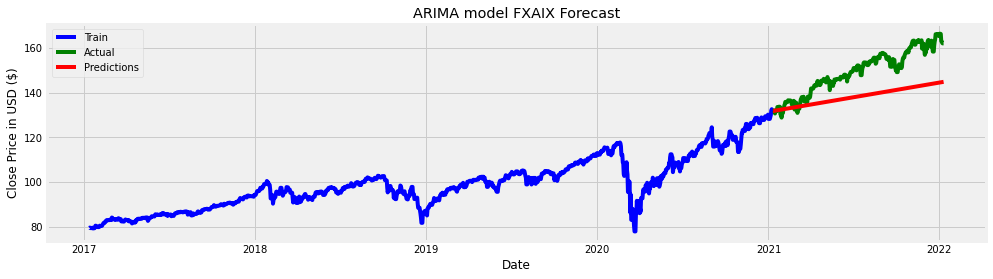

In [ ]:
plt.figure(figsize=(15,4))
plt.title('ARIMA model FXAIX Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price in USD ($)')
plt.plot(FXAIX_train,c="blue",label='Train')
plt.plot(FXAIX_test,c='green',label='Actual')
plt.plot(yhat, c='red',label='Predictions')
plt.legend()
plt.show()

### LSTM Model

Our next modeling technique will be the LSTM model. This is a special type of RNN.

In [ ]:
data = FXAIX.filter(['close'])
dataset = data.values
cutoff = int(len(dataset)*0.8)
cutoff

1460

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01775215],
       [0.01944821],
       [0.01684758],
       ...,
       [0.9512664 ],
       [0.9512664 ],
       [0.9512664 ]])

In [ ]:
# create scaled training set
train_data = scaled_data[0:cutoff,:]
X_train = []
y_train = []

for i in range(100,len(train_data)):
    X_train.append(train_data[i-100:i,0])
    y_train.append(train_data[i,0])

In [ ]:
# convert X_train and y_train to numpy arrays for training the model
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# reshape X_train for LSTM model
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(1360, 100)
(1360, 100, 1)


In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
# compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
# train the model
model.fit(X_train, y_train, batch_size=32,epochs=100)

Epoch 1/100
43/43 [==============================] - 8s 97ms/step - loss: 0.0058
Epoch 2/100
43/43 [==============================] - 4s 96ms/step - loss: 7.7774e-04
Epoch 3/100
43/43 [==============================] - 4s 95ms/step - loss: 6.7104e-04
Epoch 4/100
43/43 [==============================] - 4s 95ms/step - loss: 6.3129e-04
Epoch 5/100
43/43 [==============================] - 4s 95ms/step - loss: 5.8808e-04
Epoch 6/100
43/43 [==============================] - 4s 96ms/step - loss: 5.1994e-04
Epoch 7/100
43/43 [==============================] - 4s 95ms/step - loss: 4.9070e-04
Epoch 8/100
43/43 [==============================] - 4s 95ms/step - loss: 4.9729e-04
Epoch 9/100
43/43 [==============================] - 4s 95ms/step - loss: 4.2847e-04
Epoch 10/100
43/43 [==============================] - 4s 95ms/step - loss: 4.7553e-04
Epoch 11/100
43/43 [==============================] - 4s 95ms/step - loss: 4.3441e-04
Epoch 12/100
43/43 [==============================] - 4s 95ms/step 

In [ ]:
# creating test data
test_data = scaled_data[cutoff-100:,:]
X_test = []
y_test = dataset[cutoff:,:]

for i in range(100,len(test_data)):
    X_test.append(test_data[i-100:i, 0])

In [ ]:
# convert X_test to numpy array
X_test = np.array(X_test)

In [ ]:
# reshape X_test for LSTM model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# get model preds
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
# get rmse
lstm_rmse = mean_squared_error(y_test,predictions,squared=False)
lstm_rmse

1.4607729878753506

In [ ]:
# plot the data
train = data[:cutoff]
actual = data[cutoff:]

actual['Predictions'] = predictions

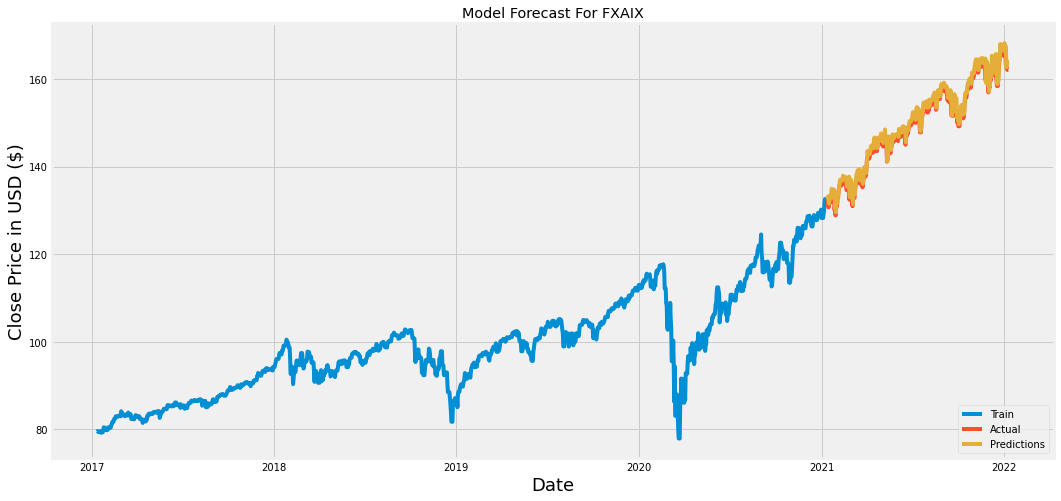

In [ ]:
# visualize 
plt.figure(figsize=(16,8))
plt.title("Model Forecast For FXAIX")
plt.xlabel("Date",fontsize=18)
plt.ylabel("Close Price in USD ($)",fontsize=18)
plt.plot(train['close'])
plt.plot(actual['close'])
plt.plot(actual['Predictions'])
plt.legend(['Train','Actual','Predictions'],loc='lower right')
plt.show()

### FBprophet Model

In [ ]:
# Fbprophet Helper functions

# formats dataframe to meet fbprophet requirements
def prep_dataframe(df):
    ts = df.copy()
    ts.rename(columns={'close':'y'},inplace=True)
    ts.index.name = 'ds'
    ts = ts.reset_index()
    ts['ds'] = ts['ds'].apply(lambda x: x.replace(tzinfo=None))
    return ts

# creates training and test set and fit the prophet model
def fit_train(data,prepared=True):
    # Format dataframe to fbprophet requirements in not already done
    if prepared == False:
        data = prep_dataframe(data)

    # Train-Test Split
    cutoff = int(data.shape[0] * 0.80)
    train = data.iloc[:cutoff]
    test = data.iloc[cutoff:]

    # Fit the model
    mod = Prophet(interval_width=0.95,weekly_seasonality=True,daily_seasonality=True)
    fitted_mod = mod.fit(train)

    if prepared == False:
        return fitted_mod, data, train, test
    else:
        return fitted_mod, train, test

# creates predictions using fitted model
def get_preds(model,test_data):
    preds = model.predict(test_data[['ds']])
    return preds[['ds','yhat_lower','yhat_upper','yhat']]

def get_rmse(preds, test_data):
    return mean_squared_error(preds['yhat'],test_data['y'],squared=False)

In [ ]:
mod, FXAIX_prepped, train, test = fit_train(FXAIX,False)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
predictions = get_preds(mod,test)

In [ ]:
fbprophet_rmse = get_rmse(predictions,test)

In [ ]:
fbprophet_rmse

11.723049956025578

In [ ]:
train = train.set_index('ds')
test = test.set_index('ds')

In [ ]:
predictions = predictions[['ds','yhat']].set_index('ds')

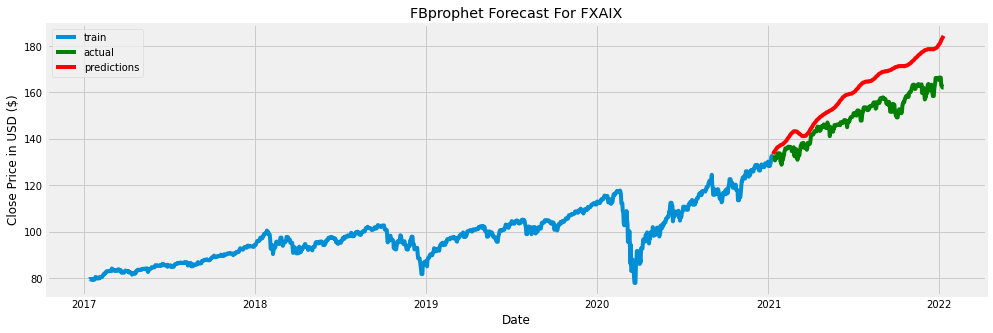

In [ ]:
plt.figure(figsize=(15,5))
plt.title('FBprophet Forecast For FXAIX')
plt.xlabel('Date')
plt.ylabel("Close Price in USD ($)")
plt.plot(train['y'],label="train")
plt.plot(test['y'],c='green',label='actual')
plt.plot(predictions['yhat'],c='red',label='predictions')
plt.legend()
plt.show()

### Evaluation of Models

Judging the models base on the rmse, we can say thet the LSTM model was the best performing model which yields the lowest RMSE. This means that the LSTM model will give us the most reliable predictions.

Our RMSE for the LSTM model tells us that we can expect our close price predictions to be off, on average, by $1.46.



In [ ]:
rmses = pd.Series( [baseline_rmse, arima_rmse, lstm_rmse, fbprophet_rmse], index=['Baseline','ARIMA','LSTM','FBprophet'])
rmses = pd.DataFrame(rmses,columns=['FXAIX_RMSEs'])
rmses = rmses.reset_index()
rmses.columns = ['Model','FXAIX_RMSEs']
rmses

,Model,FXAIX_RMSEs
0,Baseline,7.390902
1,ARIMA,12.634809
2,LSTM,1.460773
3,FBprophet,11.723050


The next lines are code used to create the model_rmses.csv file that will be used in the Evaluation notebook. No need to rerun the next lines.

In [ ]:
# from google.colab import drive
# drive.mount('/drive')

Mounted at /drive


In [ ]:
# rmses_df = pd.read_csv('/drive/My Drive/Stock_Forecasting/Modeling/model_rmses.csv')
# rmses_df = rmses_df.drop('Unnamed: 0',axis=1)
# rmses_df

,Model,NASDX_RMSEs,IVV_RMSEs,VFIAX_RMSEs,VTSAX_RMSEs,QQQ_RMSEs,SWPPX_RMSEs,SWTSX_RMSEs
0,Baseline,1.588590,21.442564,19.797750,5.585475,17.215619,3.267562,3.917987
1,ARIMA,2.292706,36.026600,33.119191,7.658805,22.830807,5.890846,5.779298
2,LSTM,0.432891,4.124593,4.080433,1.077314,5.309794,0.691213,0.820236
3,FBprophet,5.670109,32.488233,31.884724,10.883668,63.844688,5.617840,7.457487


In [ ]:
# rmses_df = pd.concat([rmses_df,rmses[['FXAIX_RMSEs']]],axis=1)
# rmses_df

,Model,NASDX_RMSEs,IVV_RMSEs,VFIAX_RMSEs,VTSAX_RMSEs,QQQ_RMSEs,SWPPX_RMSEs,SWTSX_RMSEs,FXAIX_RMSEs
0,Baseline,1.588590,21.442564,19.797750,5.585475,17.215619,3.267562,3.917987,7.390902
1,ARIMA,2.292706,36.026600,33.119191,7.658805,22.830807,5.890846,5.779298,12.634809
2,LSTM,0.432891,4.124593,4.080433,1.077314,5.309794,0.691213,0.820236,1.460773
3,FBprophet,5.670109,32.488233,31.884724,10.883668,63.844688,5.617840,7.457487,11.723050


In [ ]:
# rmses_df.to_csv('/drive/My Drive/Stock_Forecasting/Modeling/model_rmses.csv')

### Forecasting Future Closing Prices

Now that we have found our best working model, we will use it to find the close prices for the next 365 days and use them to calculate the ROI from the current day to the last forecasted day.

In [ ]:
# next 365 days close price predictions
future_predictions = []

last_100_days = X_test[-1] # real

while len(future_predictions) != 365:
    # reshape the input array for the lstm model
    X = np.reshape(last_100_days, (last_100_days.shape[1], last_100_days.shape[0], 1))
    # make one new prediction
    forecast = model.predict(X) 
    # update last_100_days dropping first value and adding the new prediction to the end of the array
    new = np.concatenate((last_100_days, forecast))
    last_100_days = new[1:]
    # append unscaled prediction to future predictions
    future_predictions.append(scaler.inverse_transform(forecast)[0])

In [ ]:
predictions_df = pd.DataFrame(future_predictions,columns=['close'])
FXAIX_copy = FXAIX.copy()
FXAIX_copy = FXAIX.reset_index()
FXAIX_copy['date'] = FXAIX_copy['date'].apply(lambda x: x.replace(tzinfo=None))
FXAIX_copy

,date,close
0,2017-01-12,79.50
1,2017-01-13,79.65
2,2017-01-14,79.42
3,2017-01-15,79.42
4,2017-01-16,79.42
...,...,...
1820,2022-01-06,162.92
1821,2022-01-07,162.29
1822,2022-01-08,162.06
1823,2022-01-09,162.06


In [ ]:
# getting dates for the next 365 days

from datetime import datetime, timedelta

def date_range(start, end):
    delta = end - start  # as timedelta
    days = [start + timedelta(days=i) for i in range(delta.days + 1)]
    return days

# last date from the data
start_date = FXAIX_copy.iloc[-1,0]

end_date = datetime(2023, 1, 10)
    
future_dates = date_range(start_date, end_date)[1:]

In [ ]:
# Create new dataframe with next 365 day close price predictions 
predictions_df['date'] = future_dates
predictions_df = predictions_df[['date','close']]
FXAIX_copy_2 = pd.concat([FXAIX_copy,predictions_df])
# Final dataframe with old data and next 365 day predictions
FXAIX_copy_2 = FXAIX_copy_2.set_index('date')

In [ ]:
# Find the ROI for the next 365 days
ROI_next_365_days = (FXAIX_copy_2.iloc[-1] - FXAIX_copy_2.iloc[-366]) / FXAIX_copy_2.iloc[-366]
print(f"Next 365 days ROI: {round(ROI_next_365_days[0]*100,2)}%")

Next 365 days ROI: 38.6%


The next lines of code were used to create the rois.csv file that will be used in the evaluation notebook. No need to rerun the next lines.

In [ ]:
# roi_df = pd.read_csv('/drive/My Drive/Stock_Forecasting/Modeling/rois.csv')
# roi_df

,Unnamed: 0,NASDX_ROI,IVV_ROI,VFIAX_ROI,VTSAX_ROI,QQQ_ROI,SWPPX_ROI,SWTSX_ROI
0,0,0.267214,0.33298,0.400738,0.421071,0.318488,0.368498,0.508993


In [ ]:
# roi_df = roi_df.drop('Unnamed: 0',axis=1)
# roi_df['FXAIX_ROI'] = ROI_next_365_days.values

In [ ]:
# roi_df

,NASDX_ROI,IVV_ROI,VFIAX_ROI,VTSAX_ROI,QQQ_ROI,SWPPX_ROI,SWTSX_ROI,FXAIX_ROI
0,0.267214,0.33298,0.400738,0.421071,0.318488,0.368498,0.508993,0.385973


In [ ]:
# roi_df.to_csv('/drive/My Drive/Stock_Forecasting/Modeling/rois.csv')